In [1]:
from imputationLibrary import forwardFilling, hotDeck, meanImputation, movingAverage, splineInterpolation, separate, randomSampleImputation
from imputationLibrary.util import util
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from tsmoothie.smoother import *
import matplotlib.pyplot as plt

In [2]:
INPUT = 'output/\CompleteWeeklyIndexes'

In [3]:
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0)
df_test = df.loc['2015-01-02':] #Selecting test data
df_train = df.loc['2000-01-01':'2015-01-01'] #Selecting training data

In [4]:
df_white_noise, df_seasonal, df_trended, df_trend_and_seasonal = separate.separate(df_train)

In [5]:
# infectious_daily_infect_emv_index, trade_US Trade Policy Uncertainty
df_white_noise.columns

Index(['vix_Volume', 'infectious_daily_infect_emv_index', 'GPR'], dtype='object')

In [6]:
df_seasonal.columns

Index(['trade_Trade Policy EMV Fraction'], dtype='object')

In [7]:
# sp500_Close, sp500_Volume, vix_Close, vix_Volume, 'dji_Close', 'dji_Volume', 'ndx_Close',
#       'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close', 'ftse_Volume',
#       'hsi_Close', 'hsi_Volume', 'n100_Close', 'n100_Volume','trade_Trade Policy EMV Fraction'
df_trended.columns

Index(['sp500_Volume', 'Overall EMV Tracker'], dtype='object')

In [8]:
# GPR, trade_Japanese Trade Policy Uncertainty, trade_US Trade Policy Uncertainty
df_trend_and_seasonal.columns

Index(['sp500_Close', 'vix_Close', 'dji_Close', 'dji_Volume', 'ndx_Close',
       'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close', 'ftse_Volume',
       'hsi_Close', 'hsi_Volume', 'n100_Close', 'n100_Volume',
       'trade_US Trade Policy Uncertainty',
       'trade_Japanese Trade Policy Uncertainty'],
      dtype='object')

In [9]:
df_seasonal_train, df_seasonal_test = randomSampleImputation.input(df.loc['2000-01-01':'2015-01-01', df_seasonal.columns], df.loc['2015-01-02':, df_seasonal.columns], sliding_window_size = 0.03)

C:\Users\silva\Anaconda3\envs\mestrado\lib\site-packages\numpy\core\fromnumeric.py:58: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [10]:
df_white_noise_train, df_white_noise_test =  meanImputation.input(df.loc['2000-01-01':'2015-01-01', df_white_noise.columns], df.loc['2015-01-02':, df_white_noise.columns])

In [11]:
df_trended_train, df_trended_test =  forwardFilling.input(df.loc['2000-01-01':'2015-01-01', df_trended.columns], df.loc['2015-01-02':, df_trended.columns])

In [12]:
df_trend_and_seasonal_train, df_trend_and_seasonal_test =  splineInterpolation.input(df.loc['2000-01-01':'2015-01-01', df_trend_and_seasonal.columns], df.loc['2015-01-02':, df_trend_and_seasonal.columns])

In [13]:
df_train = pd.concat([df_seasonal_train, df_white_noise_train, df_trended_train, df_trend_and_seasonal_train], axis=1, join='outer')

In [14]:
df_seasonal_test.index = df_white_noise_test.index

In [15]:
df_test = pd.concat([df_seasonal_test, df_white_noise_test, df_trended_test, df_trend_and_seasonal_test], axis=1, join='outer')

In [16]:
# Subsample para weekly

# Generating weekly sampled dataset
def generate_weekly(df, initial_friday):
    df_friday = initial_friday #datetime(2000,1,7)

    df_weekly = pd.DataFrame(columns = df.columns)
    
    while df_friday <= df.tail(1).index:
        df_weekly = df_weekly.append(df.loc[df_friday])
        df_friday+=timedelta(days=7)
    return df_weekly

In [17]:
### USE KALMAN FILTER TO SMOOTH ALL DATA (ONLY VISUALIZATION PURPOSE) ###

smoother_train = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother_train.smooth(df_train.T)

smoother_test = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother_test.smooth(df_test.T)

<tsmoothie.smoother.KalmanSmoother>

C:\Users\silva\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


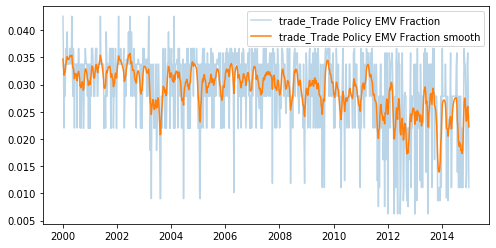

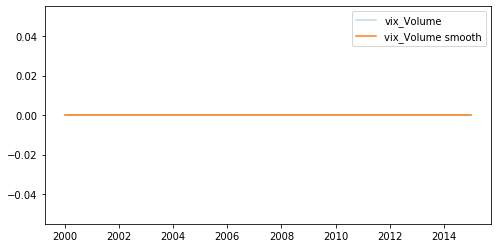

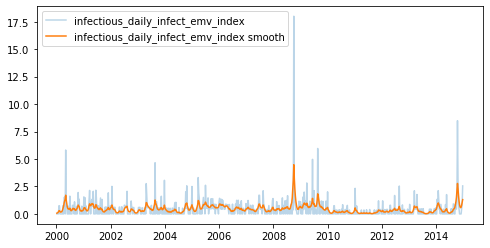

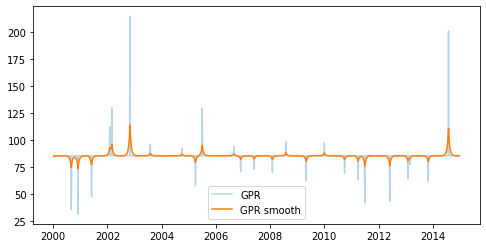

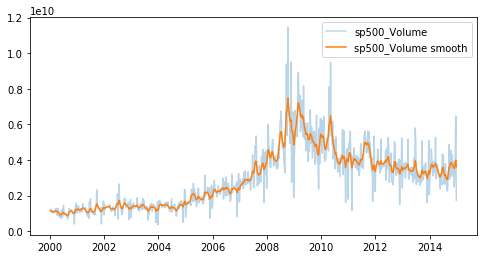

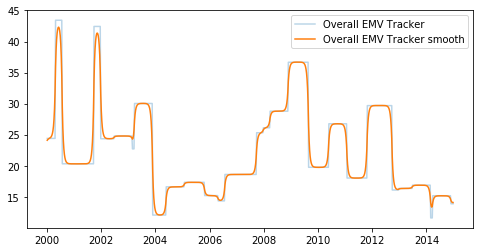

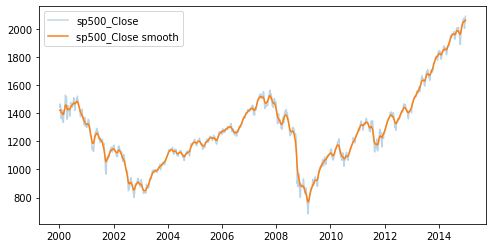

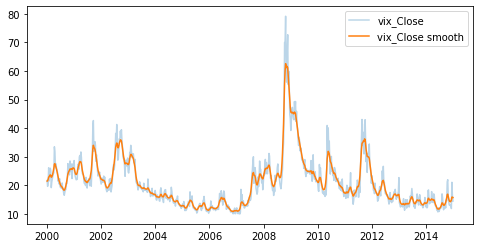

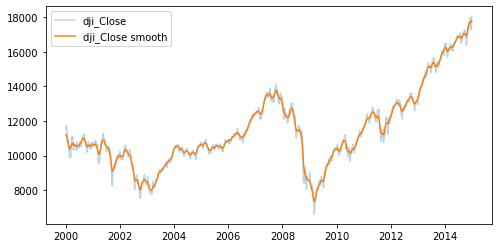

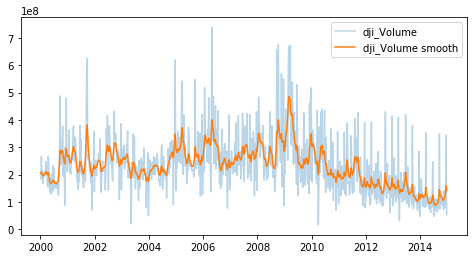

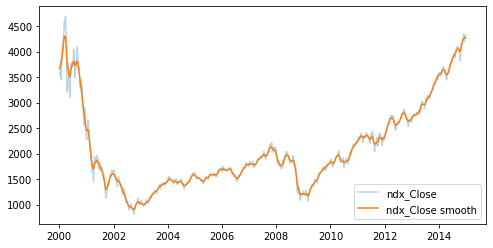

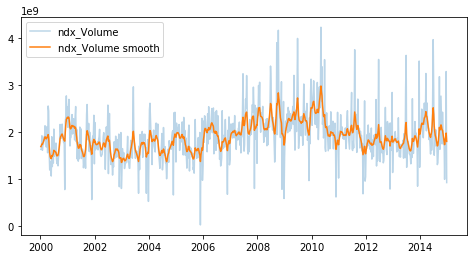

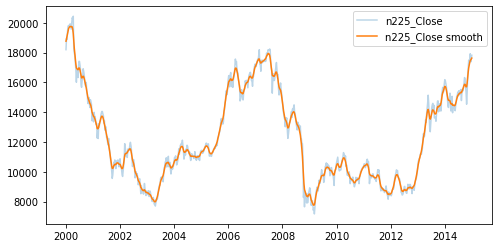

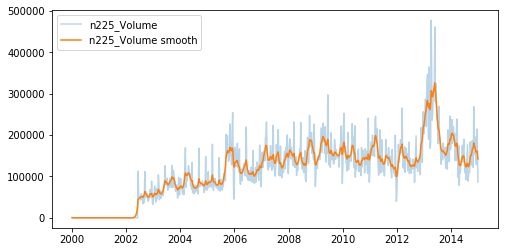

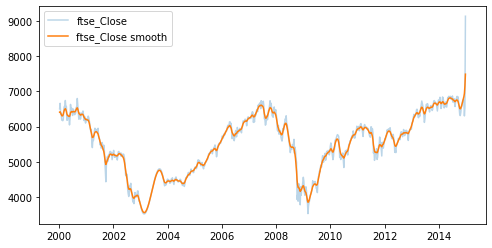

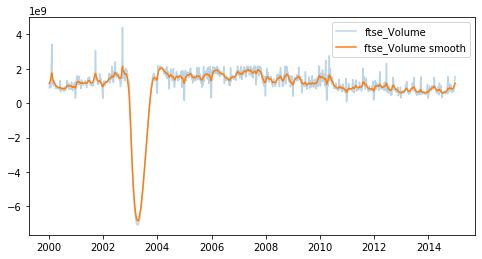

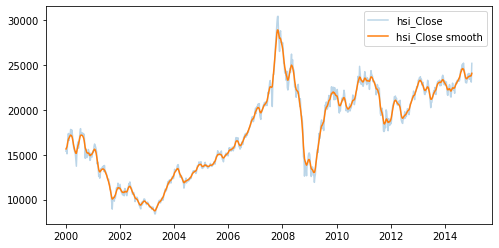

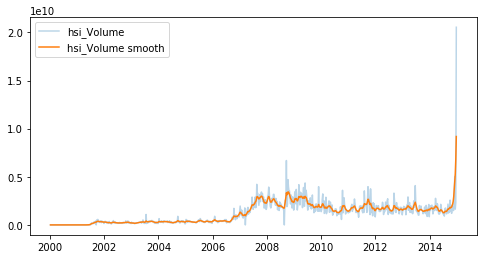

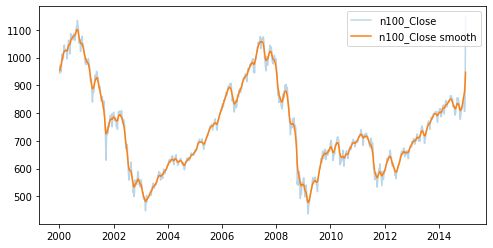

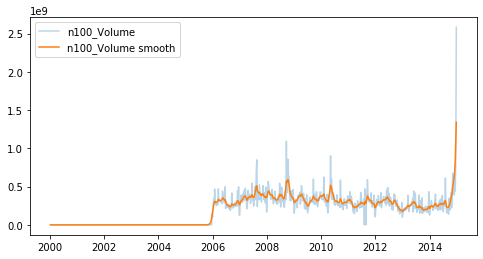

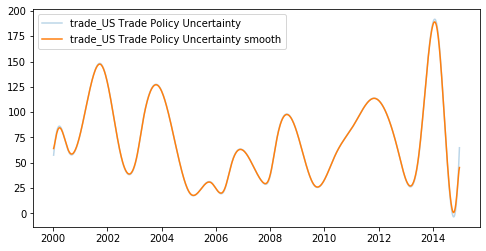

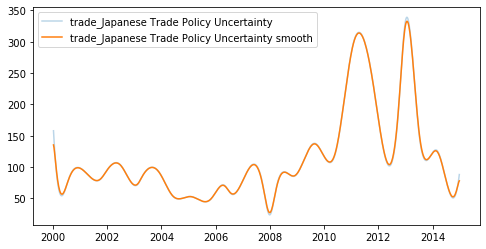

In [18]:
for i, name in enumerate(df_train.columns):
    plt.figure(figsize=(8,4))
    plt.plot(df_train.index, smoother_train.data[i], label=name, alpha=0.3)
    plt.plot(df_train.index, smoother_train.smooth_data[i], label=name+' smooth')
    plt.legend(); plt.show()

In [19]:
df_train = pd.DataFrame(data = smoother_train.smooth_data.T, index = df_train.index, columns= df_train.columns)
df_test = pd.DataFrame(data = smoother_test.smooth_data.T, index = df_test.index, columns= df_test.columns)

In [20]:
df_train_weekly = generate_weekly(df_train, datetime(2000,1,7))
df_test_weekly = generate_weekly(df_test, datetime(2015,1,2))

In [21]:
df_test_weekly.shape

(272, 22)

In [22]:
df_test.head()

,trade_Trade Policy EMV Fraction,vix_Volume,infectious_daily_infect_emv_index,GPR,sp500_Volume,Overall EMV Tracker,sp500_Close,vix_Close,dji_Close,dji_Volume,...,n225_Close,n225_Volume,ftse_Close,ftse_Volume,hsi_Close,hsi_Volume,n100_Close,n100_Volume,trade_US Trade Policy Uncertainty,trade_Japanese Trade Policy Uncertainty
2015-01-02,0.028398,0.0,0.644941,84.525919,3.343427e+09,13.605464,2034.078964,18.113223,17613.724694,9.896444e+07,...,16781.789660,146397.967365,6555.698977,6.158192e+08,23876.014720,1.851075e+09,852.138942,4.854052e+08,-2.252371e+27,-1.056649e+27
2015-01-09,0.026999,0.0,0.579659,84.793037,3.486684e+09,13.707989,2036.566343,18.148668,17628.534323,1.031856e+08,...,16997.786047,150268.769567,6588.607182,6.698449e+08,24007.907116,1.867366e+09,860.086944,5.180214e+08,-1.464057e+27,-6.868291e+26
2015-01-16,0.029265,0.0,0.447532,84.964417,3.654218e+09,13.773752,2037.347577,18.301522,17621.150068,1.093760e+08,...,17173.300415,153139.125609,6638.755334,7.100936e+08,24156.306988,1.790046e+09,875.146196,5.542012e+08,-9.582341e+26,-4.495337e+26
2015-01-23,0.030217,0.0,0.404168,85.074365,3.741022e+09,13.815913,2041.659032,17.922332,17635.280176,1.093541e+08,...,17410.089902,152402.145349,6706.319620,7.311478e+08,24314.144668,1.727277e+09,892.637470,5.825518e+08,-6.337852e+26,-2.973259e+26
2015-01-30,0.030045,0.0,0.440904,85.144923,3.860981e+09,13.842922,2043.884341,17.793371,17641.565950,1.117889e+08,...,17625.920917,155630.318153,6748.294802,7.304847e+08,24363.570014,1.534785e+09,906.270980,5.663306e+08,-4.257869e+26,-1.997482e+26


In [23]:
df_train_weekly.to_csv(r'output\/CompleteIndexesWeeklyTrainNatureKalman.csv', index = True)
df_test_weekly.to_csv(r'output\/CompleteIndexesWeeklyTestNatureKalman.csv', index = True)

In [24]:
df

,sp500_Close,sp500_Volume,vix_Close,vix_Volume,dji_Close,dji_Volume,ndx_Close,ndx_Volume,n225_Close,n225_Volume,...,hsi_Close,hsi_Volume,n100_Close,n100_Volume,Overall EMV Tracker,infectious_daily_infect_emv_index,GPR,trade_US Trade Policy Uncertainty,trade_Japanese Trade Policy Uncertainty,trade_Trade Policy EMV Fraction
2000-01-07,1441.469971,1.225200e+09,21.719999,0.0,11522.559570,1.849000e+08,3529.600098,1.634930e+09,18193.410156,0.0,...,15405.629883,0.000000e+00,943.880005,0.0,NaN,0.00,NaN,NaN,NaN,NaN
2000-01-14,1465.150024,1.085900e+09,19.660000,0.0,11722.980469,2.668300e+08,3704.739990,1.656630e+09,18956.550781,0.0,...,15542.230469,0.000000e+00,973.859985,0.0,NaN,0.00,NaN,NaN,NaN,NaN
2000-01-21,1441.359985,1.209800e+09,20.820000,0.0,11251.709961,2.058400e+08,3849.959961,1.923680e+09,18878.089844,0.0,...,15108.410156,0.000000e+00,951.510010,0.0,NaN,0.00,NaN,NaN,NaN,NaN
2000-01-28,1360.160034,1.095800e+09,26.139999,0.0,10738.870117,1.830900e+08,3446.129883,1.616370e+09,19434.779297,0.0,...,16185.940430,0.000000e+00,948.210022,0.0,24.412899,0.00,NaN,71.914247,117.577146,0.033573
2000-02-04,1424.369995,1.045100e+09,21.540001,0.0,10963.799805,1.665900e+08,3874.370117,1.751450e+09,19763.130859,0.0,...,NaN,NaN,1010.429993,0.0,NaN,0.75,NaN,NaN,NaN,NaN
2000-02-11,1387.119995,1.025700e+09,24.420000,0.0,10425.209961,1.935400e+08,3968.889893,1.738590e+09,NaN,NaN,...,17380.300781,0.000000e+00,1014.169983,0.0,NaN,0.74,NaN,NaN,NaN,NaN
2000-02-18,1346.089966,1.042300e+09,26.000000,0.0,10219.519531,2.089300e+08,3965.750000,1.898410e+09,19789.029297,0.0,...,16599.160156,0.000000e+00,992.530029,0.0,NaN,0.00,NaN,NaN,NaN,NaN
2000-02-25,1333.359985,1.065200e+09,25.200001,0.0,9862.120117,1.952400e+08,4178.580078,1.825500e+09,19817.880859,0.0,...,17200.980469,0.000000e+00,1004.719971,0.0,NaN,0.00,NaN,NaN,NaN,NaN
2000-03-03,1409.170044,1.150300e+09,19.209999,0.0,10367.200195,2.104600e+08,4442.870117,2.136530e+09,19927.539063,0.0,...,17285.240234,0.000000e+00,1042.400024,0.0,NaN,0.00,NaN,NaN,NaN,NaN
2000-03-10,1395.069946,1.138800e+09,21.240000,0.0,9928.820313,1.974400e+08,4587.160156,1.992170e+09,19750.400391,0.0,...,17831.859375,0.000000e+00,1045.270020,0.0,NaN,0.00,NaN,NaN,NaN,NaN
